In [1]:
import numpy as np
import pandas as pd
import datetime
from model2_cpx import Net_cpx_2D, Net_cpx, Net_MS_cpx
import time
import torch.optim as optim
from scipy import io
import argparse
import os                    
import torch
from losses import SSIMLoss2D

from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py  
import matplotlib.pyplot as plt
import h5py  
import matplotlib
from PIL import Image
import math
from sklearn.metrics import confusion_matrix
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" #USE gpu 1, gp0 cannot be used for some reason
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


In [3]:
epoch_num = 3
num_workers = 0

current_data = '/home/alphabet/DL-PF/singlecoil_codes/'
# current_data_file = current_data + 'Save/'

current_data_file = current_data + 'generated_dataset/'

os.makedirs(current_data+'/model_save'+'/', exist_ok=True)
model_save_path = current_data + '/model_save'+'/'

class prepareData(Dataset):
    def __init__(self, train_or_test):
        self.files = os.listdir(current_data_file+train_or_test)
        self.train_or_test= train_or_test

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        c=current_data_file+self.train_or_test+'/'+self.files[idx]
        
        data = torch.load(current_data_file+self.train_or_test+'/'+self.files[idx])
        return data['k-space'],  data['label']
trainset = prepareData('train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=num_workers) #Change batch size to 16

validationset = prepareData('valid')
validationloader = torch.utils.data.DataLoader(validationset, batch_size=1,shuffle=True, num_workers=num_workers)

testset = prepareData('test')
testloader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=False, num_workers=num_workers)

model = Net_cpx().to(device)
# print(model)


In [4]:
import torch.nn.functional as F
class MixedL1L2Loss(torch.nn.Module):
    def __init__(self):
        super(MixedL1L2Loss, self).__init__()

    def forward(self, input, target):
        l1_loss = F.l1_loss(input, target)
        l2_loss = F.mse_loss(input, target)
        mixed_loss = l1_loss + l2_loss
        return mixed_loss

In [5]:
criterion1 = nn.L1Loss()
# criterion1 = MixedL1L2Loss()

# lr = 0.0002
# nx = 218
# ny = 170


# lr = 0.0002
lr = 0.0002
nx = 256
ny = 256
nc = 2

weight_decay = 0.000
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

ssim = SSIMLoss2D()
# ssim = SSIMLoss2D_MC(in_chan=2)

shape y torch.Size([4, 2, 256, 256])
label shape (256, 256)
Finished Training


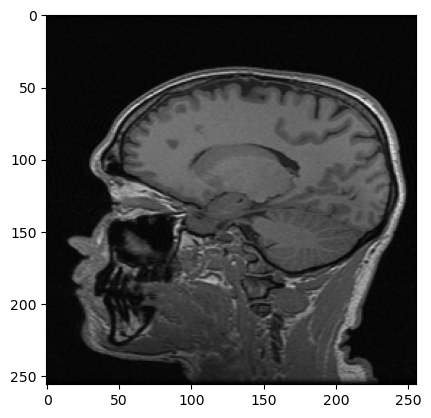

In [14]:
loss_train_list = []
loss_validation_list = []

for epoch in range(1):   #set to 0 for no running the training
    
    loss_batch = []
    time_start=time.time()    
    for i, data in enumerate(trainloader, 0):
        if i >= 1:
            break  # Limiting to 40 batches per epoch
        inputs = data[0].reshape(-1,nc,ny,nx) ##single slice

        inputs_1 = inputs[:,0,:,:] + 1j * inputs[:,1,:,:]
        freq= np.fft.ifftshift(inputs_1 ,axes=(1,2))
        image_k= np.fft.ifft2(freq ,axes=(1,2))
        image_k= np.fft.fftshift(image_k,axes=(1,2))  #I will see if using it or not is required

        real_part = np.real(image_k)
        imaginary_part = np.imag(image_k)

        # Stack along a new axis to create a new dimension
        new_image_k = np.stack((real_part, imaginary_part), axis=1)
        image_k = torch.tensor(new_image_k,dtype=torch.float)


        
        x = image_k
        or_im = x
        nsize = x.size()
        pf = math.floor(nsize[3] * 0.25)
        pf_com = nsize[3] - pf
        mid = int(nsize[3]/2)

        or_k = torch.complex(or_im[:, 0, :, :], or_im[:, 1, :, :])
        or_k = torch.fft.ifftshift(or_k, dim=(1, 2))
        or_k = torch.fft.fft2(or_k, dim=(1, 2))
        or_k =  torch.fft.fftshift(or_k, dim=(1, 2))

        y = x
        for i in range(3):
            x = y
            new_k = torch.complex(x[:, 0, :, :], x[:, 1, :, :])
            new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
            new_k = torch.fft.fft2(new_k, dim=(1, 2))
            new_k = torch.fft.fftshift(new_k, dim=(1, 2))

            new_k[:, :, pf:mid] = or_k[:, :,pf:mid]
            new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
            new_k = torch.fft.ifft2(new_k, dim=(1, 2))
            new_k =  torch.fft.fftshift(new_k, dim=(1, 2))
            new_k = torch.stack((torch.real(new_k), torch.imag(new_k)), dim=1)
            x = x +  (new_k - or_im)
            # print("x shape",x.shape)
            
        new_k = torch.complex(y[:, 0, :, :], y[:, 1, :, :])
        new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
        new_k = torch.fft.fft2(new_k, dim=(1, 2))
        new_k = torch.fft.fftshift(new_k, dim=(1, 2))
        new_k[:, :, :pf] = or_k[:, :, :pf]
        new_k[:, :, mid:] = or_k[:, :, mid:]
        new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
        new_k = torch.fft.ifft2(new_k, dim=(1, 2))
        new_k =  torch.fft.fftshift(new_k, dim=(1, 2))
        y = torch.stack((torch.real(new_k), torch.imag(new_k)), dim=1)

        print('shape y',y.shape)






        
        plt.imshow((np.abs(np.fft.fftshift((y[1,0,:,:] + 1j* y[1,1,:,:])))),cmap='gray')
        # plt.imshow(np.log(np.abs(or_k[1,:,:])),cmap ='gray')
        
        label = data[1].reshape(-1,2,ny,nx)
        
        label_cpu = label.cpu().numpy()
        label = np.array(label_cpu[1,0,:,:]) + np.array(label_cpu[1,1,:,:]) *1j
        label_shape =label.shape
        print("label shape",label_shape)


        freq= np.fft.ifftshift(label ,axes=(0,1))
        freq= np.fft.ifft2(freq ,axes=(0,1))
        label_image= np.fft.ifftshift(freq,axes=(0,1)) 

        label_image = np.fft.ifftshift(label_image)

    


        
        # total = np.fft.fftshift(total)
        # plt.imshow(np.abs(np.fft.fftshift(kspace_normalized)),cmap='gray', vmin=0, vmax=0.04)


        


print('Finished Training')


In [ ]:
loss_train_list = []
loss_validation_list = []

for epoch in range(epoch_num):   #set to 0 for no running the training
    model.train()

    loss_batch = []
    time_start=time.time()    
    for i, data in enumerate(trainloader, 0):
        if i >= 36:
            break  # Limiting to 40 batches per epoch
        inputs = data[0].reshape(-1,nc,ny,nx).to(device) ##single slice
        label = data[1].reshape(-1,2,ny,nx).to(device) 
        print("label shape",label.shape)
        if nc == 6:
            labels= label
            labels[:,0,:,:]= label[:,0,:,:] +inputs[:,0,:,:]
            labels[:,1,:,:]= label[:,1,:,:] +inputs[:,3,:,:]
        else:
            labels = inputs + label    

        outs = model(inputs)

        
        loss = criterion1(outs, labels) 
        
        if loss.item() < 0.3:
            loss = ssim(outs, labels,1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch.append(loss.item())  
        if (i)%5==0:
            print('epoch:%d - %d, loss:%.10f'%(epoch,i,loss.item()))
        # break
        # h=0
    loss_train_list.append(round(sum(loss_batch) / len(loss_batch),10))
    print(loss_train_list)
    time_end=time.time()
    print('time cost for training',time_end-time_start,'s')

    model.eval()     # evaluation
    loss_batch = []
    print('\n validation...')
    time_start=time.time()
    for i, data in enumerate(validationloader, 0):
        inputs = data[0].reshape(-1,nc,ny,nx).to(device)
        label = data[1].reshape(-1,2,ny,nx).to(device) 
        if nc ==6:
            labels= label
            labels[:,0,:,:]= label[:,0,:,:] +inputs[:,0,:,:]
            labels[:,1,:,:]= label[:,1,:,:] +inputs[:,3,:,:]
        else:
            labels = inputs + label

        with torch.no_grad():
            outs = model(inputs)

        
        loss = criterion1(outs, labels)
        if loss.item() < 0.3:
            loss = ssim(outs, labels,1)   
            
        loss_batch.append(loss.item())
        
    time_end=time.time()
    print('time cost for validation',time_end-time_start,'s')
    loss_validation_list.append(round(sum(loss_batch) / len(loss_batch),10))
    print(loss_validation_list)

    torch.save(model, os.path.join(model_save_path, 'epoch-%d-%.10f.pth' % (epoch, loss.item())))

    # if (epoch+1) % 2 == 0:
    #     lr = max(5e-5,lr*0.8)
    #     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

print('Finished Training')


input shape torch.Size([4, 2, 256, 256])
image shape (256, 256)
label shape torch.Size([4, 2, 256, 256])


In [ ]:
# # Plotting the loss curves
# plt.figure(figsize=(10, 5))
# plt.plot(loss_train_list, label='Training Loss')
# plt.plot(loss_val_list, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Curves')
# plt.legend()
# plt.grid(True)
# plt.show()

# print('Finished Training')

# Plotting the loss
plt.plot(loss_train_list, label='Training Loss')
plt.plot(loss_validation_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
model_path = '/home/alphabet/'  # Provide the path to your saved model
trained_model = torch.load(model_path)

In [9]:
trained_model.eval()
try:
    input_data, label_data = next(iter(testloader))
except StopIteration:
    print("No more data in the testloader.")

In [10]:
with torch.no_grad():
    input_data = input_data.to(device)
    output = trained_model(input_data)

In [11]:
print("Output size:", output.size())

Output size: torch.Size([1, 2, 256, 256])


In [12]:
input_array = input_data.squeeze().cpu().numpy()
label_array = label_data.squeeze().cpu().numpy()
output_array = output.squeeze().cpu().numpy()

# Display the shape of the arrays
print("Input array shape:", input_array.shape)
print("Label array shape:", label_array.shape)
print("Output array shape:", output_array.shape)

Input array shape: (2, 256, 256)
Label array shape: (2, 256, 256)
Output array shape: (2, 256, 256)


In [13]:
input_image = input_array[0,:,:] + 1j* input_array[1,:,:]

label_image = label_array[0,:,:] + 1j* label_array[1,:,:]

output_image = output_array[0,:,:] + 1j* output_array[1,:,:]


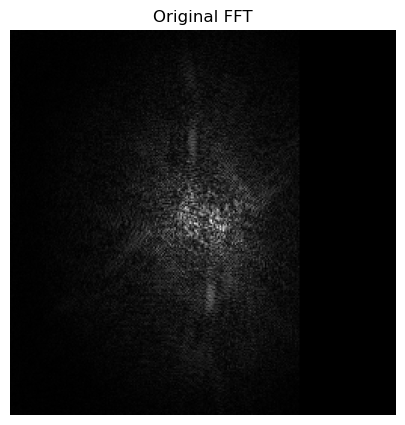

In [14]:

fft_image = np.fft.fft2(input_image)

fft_shifted = np.fft.fftshift(fft_image)

plt.figure(figsize=(10, 5))

plt.imshow((np.abs(fft_image)), cmap='gray')
plt.title('Original FFT')
plt.axis('off')
plt.show()

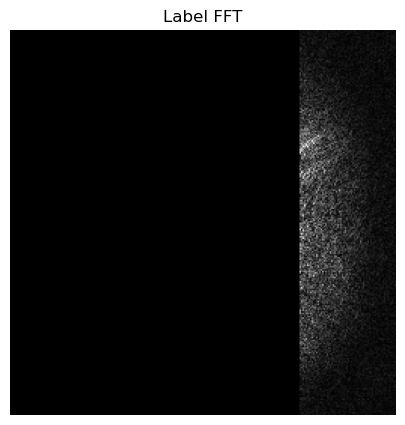

In [15]:
fft_image = np.fft.fft2(label_image)

fft_shifted = np.fft.fftshift(fft_image)

plt.figure(figsize=(10, 5))

plt.imshow(np.abs(fft_image), cmap='gray')
plt.title('Label FFT')
plt.axis('off')
plt.show()

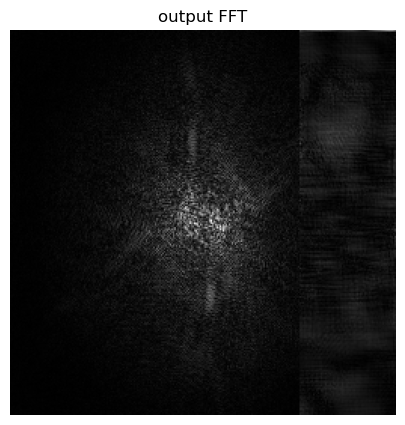

In [16]:
fft_image = np.fft.fft2(output_image)

fft_shifted = np.fft.fftshift(fft_image)

plt.figure(figsize=(10, 5))

plt.imshow((np.abs(fft_image)), cmap='gray')
plt.title('output FFT')
plt.axis('off')

plt.show()

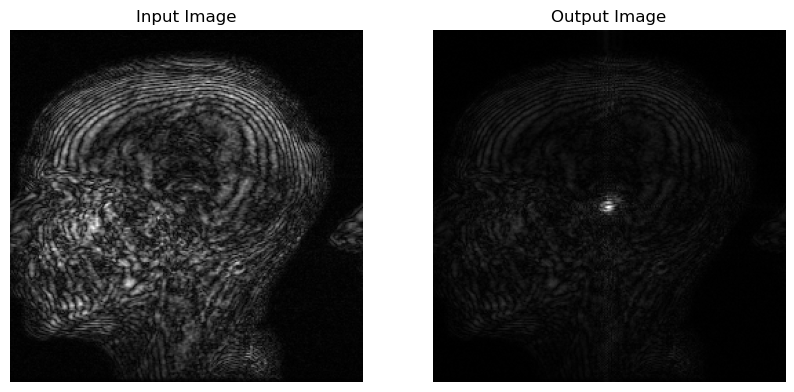

In [17]:
# Take absolute values of the complex images
abs_input_image = np.abs(np.fft.fftshift(input_image))
abs_label_image = np.abs(np.fft.fftshift(label_image))
abs_output_image = np.abs(np.fft.fftshift(output_image))

# Create a figure and set its size
plt.figure(figsize=(10, 5))

# Plot input_image
plt.subplot(1, 2, 1)
plt.imshow(abs_input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# # Plot label_image
# plt.subplot(1, 3, 2)
# plt.imshow(abs_label_image, cmap='gray')
# plt.title('Label Image')
# plt.axis('off')

# Plot output_image
plt.subplot(1, 2, 2)
plt.imshow(abs_output_image, cmap='gray')
plt.title('Output Image')
plt.axis('off')

# Show the plot
plt.show()

In [ ]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt

# # Read the image
# image = cv2.imread('input_image.jpg', cv2.IMREAD_GRAYSCALE)

# # Perform Fourier transform
# f_transform = np.fft.fft2(image)
# f_transform_shifted = np.fft.fftshift(f_transform)
# magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))

# # Inverse Fourier transform
# f_transform_inverse_shifted = np.fft.ifftshift(f_transform_shifted)
# image_back = np.fft.ifft2(f_transform_inverse_shifted)
# image_back = np.abs(image_back)

# # Plot original and processed images
# plt.subplot(121), plt.imshow(image, cmap='gray')
# plt.title('Input Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(image_back, cmap='gray')
# plt.title('Inverse Fourier Transform'), plt.xticks([]), plt.yticks([])
# plt.show()